# Classification Assesment Technical Report


## To run the code:

 * Make sure all data being used is in the appropriate path(data/..)
 * Using the correct python version (>3) 
 * Make sure all the libraries being used are installed on your machine.

## Workflow implemented for this assesment :
        
 1. Import data in the enviroment
 2. Exploration analysis and summary statistics
  * Structure Checking
  * Features correlated with respone ('target')
  * Feature Visualisation Overview
 3. Explore 3 candidate models
  * Fit models on full dataset
  * Reduce dimnesions of training
  * Fit models on reduced dimensions
  * Reduced Dimensions further explored
  * Hyperparameter tuning
 4. Compare final results
 5. Number of covariate with Accuracy trade-off
  * Fit XGBoost Classifier with different number of covariates
  * Plot the Acuuracy with Number of covariates trade-off

## [1] Importing the dataset into the python enviroment

In this section, the appropriate libraries that will be used in the following process and the datasets used are imported. Please note that all the libraries being imported must be installed on the local machines for the following import statements to be executed successfully.

In [1]:
# Important libraries for data frame manipulations.
import pandas as pd
import numpy as np
import sys as sys

# For fitting logistic regression.
from sklearn.linear_model import LogisticRegression

# For fitting a random forest.
from sklearn.ensemble import RandomForestClassifier

# For fitting a decision tree.
from sklearn.tree import DecisionTreeClassifier

# For fitting a XGBClassifier
from xgboost import XGBClassifier

# Importing accuracy_score to auto calculate our classifiers accuracy.
from sklearn.metrics import accuracy_score

# Finding static metrics.
import statistics

# To apply a gridsearch in hyperparameters for random forest.
from sklearn.model_selection import GridSearchCV

# To create graphs/plots to visualisation feature relations.
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Reading in the training and testing set already provided.
training_data = pd.read_csv("data/train.csv")
testing_data = pd.read_csv("data/test.csv")

## [2] Exploration Analysis (applied on the data)

### [2.1] Structure checking of training and test

This step is fundamental for the construction of our candidate (models) classifiers. It is also important to help confirm that the two datasets we are working on have the same strucuture (covariates). However, this step is undertaken with extreme caution, as the test data must not be viewed.

In [3]:
# Having info analysis on the training dataset.
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 32 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      300000 non-null  int64  
 1   cat0    300000 non-null  object 
 2   cat1    300000 non-null  object 
 3   cat2    300000 non-null  object 
 4   cat3    300000 non-null  object 
 5   cat4    300000 non-null  object 
 6   cat5    300000 non-null  object 
 7   cat6    300000 non-null  object 
 8   cat7    300000 non-null  object 
 9   cat8    300000 non-null  object 
 10  cat9    300000 non-null  object 
 11  cat10   300000 non-null  object 
 12  cat11   300000 non-null  object 
 13  cat12   300000 non-null  object 
 14  cat13   300000 non-null  object 
 15  cat14   300000 non-null  object 
 16  cat15   300000 non-null  object 
 17  cat16   300000 non-null  object 
 18  cat17   300000 non-null  object 
 19  cat18   300000 non-null  object 
 20  cont0   300000 non-null  float64
 21  cont1   30

In [4]:
# Having info analysis on the testing dataset
testing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      200000 non-null  int64  
 1   cat0    200000 non-null  object 
 2   cat1    200000 non-null  object 
 3   cat2    200000 non-null  object 
 4   cat3    200000 non-null  object 
 5   cat4    200000 non-null  object 
 6   cat5    200000 non-null  object 
 7   cat6    200000 non-null  object 
 8   cat7    200000 non-null  object 
 9   cat8    200000 non-null  object 
 10  cat9    200000 non-null  object 
 11  cat10   200000 non-null  object 
 12  cat11   200000 non-null  object 
 13  cat12   200000 non-null  object 
 14  cat13   200000 non-null  object 
 15  cat14   200000 non-null  object 
 16  cat15   200000 non-null  object 
 17  cat16   200000 non-null  object 
 18  cat17   200000 non-null  object 
 19  cat18   200000 non-null  object 
 20  cont0   200000 non-null  float64
 21  cont1   20

From the results displayed in the above cells, we can confirm that the two datasets do not hold any null values and they are of the same design and structure.

<br>

Following are the insights gathered from this initial analysis:
 * Both datasets contain 19 factor type covariates
 * Both datasets contain 11 float type covariates
 * The training dataset has 1 extra column of type int which is the response variable of our training dataset
 * The training set consists of 300K rows
 * The testing set consists of 200K rows
 


Our next step is to check the different levels for each factor covariate. The reason behind this action is that in Python the testing and training set must have the exact number of factor levels for the identical covariate. When we apply 1-hot-encoder, each level will act as a unique covariate. With this being said if one factor covariate has different number of levels between the two sets, the design structure will not be correct.

**1-Hot-Encoder** is a method used in Python to overcome the different levels of the categorical (string) columns of the data. Given that Python models only understand numerical values, we need to convert the string data to numerical without implementing a mathematical meaning to them. This technique creates a new column for **each** different level and fills the cells with **binary values** (1 = true, 0 = false). 

In [5]:
# Using describe function to check the levels of the categories in training dataset.
training_data.describe(include=[object])
  

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18
count,300000,300000,300000,300000,300000,300000,300000,300000,300000,300000,300000,300000,300000,300000,300000,300000,300000,300000,300000
unique,2,15,19,13,20,84,16,51,61,19,299,2,2,2,2,4,4,4,4
top,A,I,A,A,E,BI,A,AH,BM,A,DJ,A,A,A,A,B,D,D,B
freq,223525,90809,168694,187251,129385,238563,187896,45818,42380,201945,31584,258932,257139,292712,160166,203574,206906,247125,255482


In [6]:
# Using describe function to check the levels of categories in testing dataset.
testing_data.describe(include=[object])

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18
count,200000,200000,200000,200000,200000,200000,200000,200000,200000,200000,200000,200000,200000,200000,200000,200000,200000,200000,200000
unique,2,15,19,13,20,84,16,51,61,19,295,2,2,2,2,4,4,4,4
top,A,I,A,A,E,BI,A,AH,BM,A,DJ,A,A,A,A,B,D,D,B
freq,149023,60152,112465,124506,86073,158916,125098,30593,28368,134223,21166,172586,171098,195016,106607,135542,137908,165066,170068


From the tabular results displayed above, we can comprehend that column 'cat10' in the testing dataset has 4 extra unique values. For this reason we will need to 1-hot-encode the categorical data for both datasets together and split them again to the beginning states.

Before we merge the two datasets and ecnode them, we need to isolate the response in the training dataset alone. Additionally we need to remove the index column from the data, because it should not be used in the training or predicting.

In [7]:
# Getting a copy of data frames to 1-hot-encode

## TRAINING DATA
train_encoder = training_data.copy()
# Need to drop response varibale from training and hold it seperate.
trainY_response = training_data['target'].copy()
train_encoder.drop('target', axis = 1, inplace = True)
# We also need to remove the index variables because they should not be considered in the model training
train_encoder.drop('id', axis = 1, inplace = True)

## TESTING DATA
test_encoder = testing_data.copy()
test_encoder.drop('id', axis = 1, inplace = True)

## MERGED DATA
# This will concatenate the test data rows below the train data
# The first 300K rows will be the train.
# The last 200K rows will be the testing.
merged_encoder = pd.concat([train_encoder, test_encoder])

In [8]:
# Using get_dummies() which is the same thing as 1-hot-encoder but ignores numerical values.
%time
merged_encoder = pd.get_dummies(merged_encoder)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.77 µs


In [9]:
# Checking if the one hot encoder worked.
merged_encoder.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500000 entries, 0 to 199999
Columns: 642 entries, cont0 to cat18_D
dtypes: float64(11), uint8(631)
memory usage: 346.7 MB


From the above result we can see that our data has become a large sparse matrix of values (from 30 columns to 642 columns). This is one of the consequences of using the 1-Hot-Encoder technique. 

The next step is to split the combined dataset back to training and testing.

In [10]:
# First 300K rows is our training set.
trainingX_data = merged_encoder.iloc[:300000,:].copy()
trainingX_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300000 entries, 0 to 299999
Columns: 642 entries, cont0 to cat18_D
dtypes: float64(11), uint8(631)
memory usage: 208.0 MB


In [11]:
# Last 200K rows is our testing set.
testingX_data = merged_encoder.iloc[300000:,:].copy()
testingX_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200000 entries, 0 to 199999
Columns: 642 entries, cont0 to cat18_D
dtypes: float64(11), uint8(631)
memory usage: 138.7 MB


### [2.2] Correlation relation with response 'target'
This section explores possible correlation relations between the covariates and the response variable. This will help us identify the covariates that influence the response value the most. The covariates that influence the response values the most are also assumed to be the most important covariates to be consider while training our models.

In [12]:
# Merge the trainingX_data with trainY_data to see the correlations
training_all = pd.concat([trainingX_data.copy(), trainY_response.copy()], axis=1)

In [13]:
%%time
# Computing correlation relations.
training_corr_influnce = training_all.corr()

CPU times: user 4min 7s, sys: 1.07 s, total: 4min 8s
Wall time: 4min 15s


In [14]:
# Printing the correlation with response in sorted way (20 most positive influential features).
training_corr_influnce["target"].sort_values(ascending=False)[:20]

target     1.000000
cat16_B    0.522759
cat15_D    0.467675
cat14_B    0.302301
cat18_D    0.299653
cat11_B    0.285503
cat0_A     0.268109
cat18_C    0.260021
cat17_C    0.237540
cont5      0.215184
cat2_Q     0.213173
cat13_B    0.205714
cat8_K     0.194427
cat1_L     0.190920
cont6      0.189832
cont8      0.183726
cont1      0.164655
cat7_AF    0.160744
cat9_A     0.156035
cat4_H     0.153590
Name: target, dtype: float64

In [15]:
# Printing the correlation with response in sorted way (20 most negative influential).
training_corr_influnce["target"].sort_values(ascending=True)[:20]

cat16_D    -0.505020
cat15_B    -0.435327
cat18_B    -0.409153
cat14_A    -0.302301
cat11_A    -0.285503
cat0_B     -0.268109
cat17_D    -0.267343
cat13_A    -0.205714
cat1_I     -0.198141
cat4_E     -0.165314
cat6_A     -0.149729
cont3      -0.148316
cat2_A     -0.141533
cat9_E     -0.126067
cat10_CR   -0.100503
cat1_A     -0.095467
cat2_C     -0.093678
cat12_B    -0.083143
cont4      -0.075585
cat7_E     -0.075031
Name: target, dtype: float64

From the results above we can see some values are close to 0, which indicates that they do not influence the response variable. Following this, further investigation on feature importance is conducted.

### [2.3] Feature Visualisation Overview

In this section, the visualisation aspects of our covariates is explored. This process will help us identify the key features that help in predicting the response target. We implement a few graphs concerning our top correlated features from the above analysis. For extra insights and visualisation overview you can visit [Full Visualisation Overview](http://localhost:8888/notebooks/EDA.ipynb)

We begin by visualizing the proportion that dictates the response target variable, to examine which values are expected to be predicted the most.

The subset of the data when target is one(TRUE) is (79461, 32) 
The subset of the data when target is zero(FALSE) is (220539, 32) 


<AxesSubplot:xlabel='target', ylabel='count'>

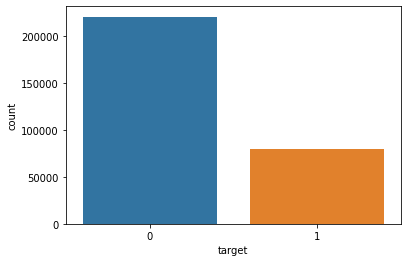

In [16]:
data_target_one = training_data[training_data['target'] == 1]
print("The subset of the data when target is one(TRUE) is {} ".format(data_target_one.shape))
data_target_zero = training_data[training_data['target'] == 0]
print("The subset of the data when target is zero(FALSE) is {} ".format(data_target_zero.shape))

sns.countplot(data =training_data, x='target')

From the graph displayed above, it is clear that most of the data is constructed with 0-value responses. There are 220K rows whose response is 0, while the 1-value responses are 80K rows. More than 2/3 of the data is being dictated by 0-value response. 

By plotting the most influential in terms of correlation features, we can check their relations.The following features will be examined:
 
 * cat16
 * cat15
 * cat18
 * cat14
 * cont5
 
For more visualisations, please visit the attached document provided [EDA](....)

* **cat16**

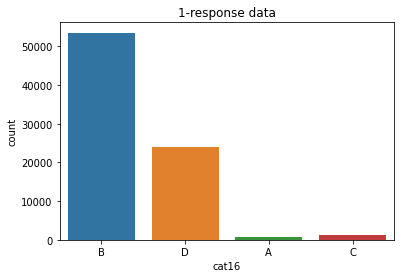

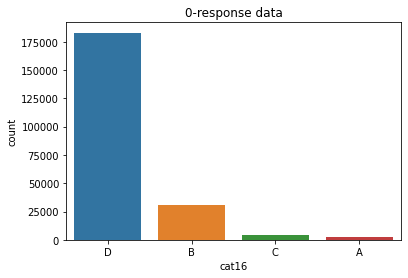

In [159]:
# cat16 plots
sns.countplot(data =data_target_one, x='cat16').set_title('1-response data')
plt.show()
sns.countplot(data =data_target_zero, x='cat16').set_title('0-response data')
plt.show()


**cat16 =>** From the two plots displayed above, we observe that level B of cat16 is highly correlated with the repsonse value 1. Since we do not have many response values where 'target=1', cat16 would be beneficial in trying to capture this target.

* **cat15**

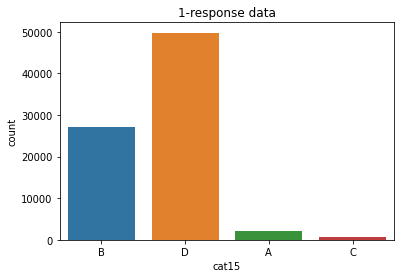

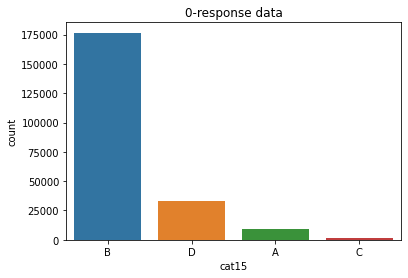

In [160]:
# cat15 plots
sns.countplot(data =data_target_one, x='cat15').set_title('1-response data')
plt.show()
sns.countplot(data =data_target_zero, x='cat15').set_title('0-response data')
plt.show()

**cat15 =>** From the above data we see that level B is the highest level combined for both responses. However tha majority of its occurence predict the 0-response. The second highest level is 'D' but it seems to predict both values equally.

* **cat18**

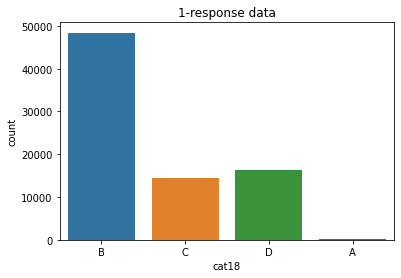

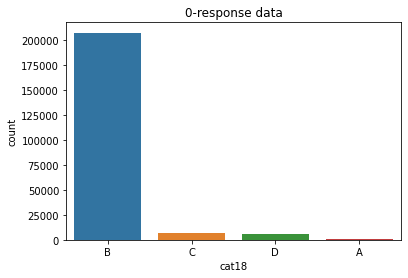

In [161]:
#cat18
sns.countplot(data =data_target_one, x='cat18').set_title('1-response data')
plt.show()
sns.countplot(data =data_target_zero, x='cat18').set_title('0-response data')
plt.show()

**cat18 =>** From the above two plots we can observe the same phenomenon as with the other features. Level 'B' dictates the occurence frequency, however it predicts response value 0 more than it predicts response value 1.

* **cat14**

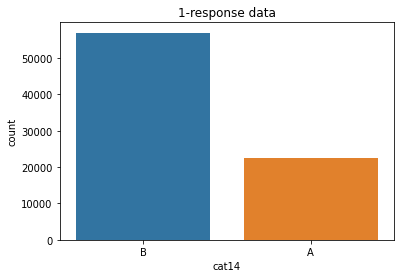

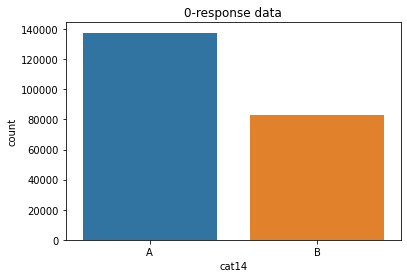

In [162]:
#cat14 
sns.countplot(data =data_target_one, x='cat14').set_title('1-response data')
plt.show()
sns.countplot(data =data_target_zero, x='cat14').set_title('0-response data')
plt.show()

**cat14 =>** From the above plots we can observe that we only have 2 levels for this feature. The differences between them are not significantly large as in other features. Both attributes mostly predict 0-response.

* **cont5**

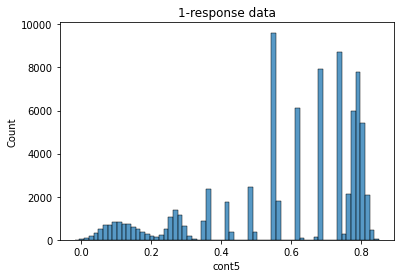

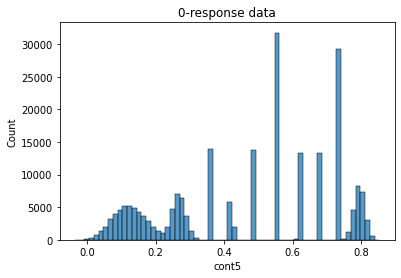

In [163]:
sns.histplot(data=data_target_one, x="cont5").set_title('1-response data')
plt.show()
sns.histplot(data=data_target_zero, x="cont5").set_title('0-response data')
plt.show()

**cont5 =>** From the two plots above, we can observe that the predictions are more or less the same (Note: axes have different scales). In both cases, it appears that the data is being distributed the same. However, most values lie in the response-1 value.

**One-Hot-Encoding** and **Correlation analysis of the response** (as an indication of what features will be valuable in our training) has now been completed.

A brief summary of the dataframes available at this point:   
 1. Before One-Hot-Encoding the Datasets
  * **training_data** = Full training dataset
  * **testing_data** = Full testing dataset
 2. After One-Hot-Encoding the Datasets
  * **merged_encoder** = Both (training and testing) datasets merged and encoded
  * **trainingX_data** = Training dataset explanatory variables (values used for training)
  * **trainY_response** = Training dataset response variable (value used to train models under construction)
  * **testingX_data** = Testing dataset explanatory variables (values used for predictions)
 3. Other Datasets (created during analysis)
  * **training_corr_influnce** = Holds correlation values between variables
  * **training_all** = Holds the 1-Hot-Encoded explanatory variables with the response, to calculate correlations
 

## [3] Explore candidate models

To check the accuracy score of our candidate models we will be modifying the 'target' column with the predicted probabilities produced by our candiated models, as per the requirements. 

Note: The prediction results must be in probability format, because the evaluation metric is done by a ROC CURVE with a threshold. For this reason the function '.predict_prob()' is used to predict the response target.

In [58]:
# Reading in the submittion structure csv, to modify and submit
# informing index column to keep correct structure.
submit_file = pd.read_csv("data/sample_submission.csv", index_col='id')

### [3.1] Fit candidate models on the full dataset

Based on our research, the following three models were chosen for this dataset.

 * **Random Forest**
 
*Random forest is one of the three models that were handpicked to be used for this dataset. This model is a commonly used classification algorithm that can be used for both classification and regression tasks. It also works well with large data sets similar to the one we are using. As the name suggests, the random forest algorithm is a collection of decision trees. It has access to all the hyperparameters available for a decision tree model and bagging classifier, giving more control over the model creation. Given that the model merges multiple decision trees and works to produce the average of the result obtained, it generates stable and accurate results through cross validation.*
 
 
In the following section, the Random Forest model is fitted using the full dataset consisting of 300K rows and 642 columns. The test dataset will be used to check the accuracy score of this model.

In [51]:
%%time
# Instantiate model with 100 decision trees 
# oob_score needs to be true to consider out of bag sampling.
Random_forest_model = RandomForestClassifier(n_estimators = 100, random_state = 42, oob_score=True)
Random_forest_model.fit(trainingX_data, trainY_response)

CPU times: user 3min 53s, sys: 12.4 s, total: 4min 5s
Wall time: 4min 9s


RandomForestClassifier(oob_score=True, random_state=42)

In [59]:
# Predicting values using the test X matrix
# we choose the 2nd column of results which is the prob predicted.
y_predicted = Random_forest_model.predict_proba(testingX_data)[:,1]
# Calling function to write the csv file
submit_file['target'] = y_predicted
submit_file.to_csv('full-forest.csv')

<font color="blue"> The random forest model has resulted in an accuracy score of **88.22%** on the test data.<font>

This will now be compared with the out of bag error produced from the model fitting.

In [60]:
# Calculating the accuracy for training with considering the OOB sample
print("Accuracy score using the training data for prediction is ", 
      Random_forest_model.oob_score_)

Accuracy score using the training data for prediction is  0.8458966666666666


<font color="blue"> Results from the above cell states that the training set prediction has an accuracy score of **84.5%** which is **4% lower** than the test dataset accuracy score. <font>

 * **Logistic Regression**
 
*This model is often used in dealing with supervised classification by generating probabilities efficiently. Results of this model are easy to interpret. Moreover, it has the advantages of being less inclined to overfitting and limits multicollinearity while fitting the classifier. Unfortunately, it does not perform well when the feature space is large, notably across extremely large datasets, particularly if categorical variables are numerous. Additionally, the violation of underlying assumptions, especially linearity on the link scale and independence of observations, might be cause of concern.*

In the following section, the Logistic Regression model is fitted using the full dataset consisting of 300K rows and 642 columns. The test dataset will be used to check the accuracy score of this model.

In [61]:
%%time
# Constructing a logistic regression.
log_reg = LogisticRegression(solver="saga", max_iter= 1000, random_state=42)
# Fitting the logistic regression
log_reg.fit(trainingX_data, trainY_response)

CPU times: user 5min 5s, sys: 3.44 s, total: 5min 9s
Wall time: 5min 18s


LogisticRegression(max_iter=1000, random_state=42, solver='saga')

In [62]:
# Predicting values using the test X matrix
# we choose the 2nd column of results which is the prob predicted.
y_predicted = log_reg.predict_proba(testingX_data)[:,1]
# Calling function to write the csv file
submit_file['target'] = y_predicted
submit_file.to_csv('full-logistic.csv')

<font color="blue"> The logistic regression model has resulted in an accuracy score of **87.736%** on the test data.<font>

 This will now be compared with the accuracy of the training data predictions.

In [44]:
# We will see how it performs with training data
train_predicted = log_reg.predict(trainingX_data)
# Calculating the accuracy
print("Accuracy score using the training data for prediction is {} %".format(accuracy_score(trainY_response, train_predicted, normalize=True)))

Accuracy score using the training data for prediction is 0.8450233333333333 %


<font color="blue"> Results from the above cell states that the training set prediction has an accuracy score of **84.5%** which is **3.5% lower** than the test dataset accuracy score. <font> However, it is important to note that the threshold used might be different.

 * **XGBClassifier**

*XGB (short for eXtreme Gradient Boosting) is a relatively new model optimized for quick interpretations and quality model performance. Due to its high performance results, XGB models have been used recently to win numerous Kaggle competitions. XGB models are able to operate efficiently on large datasets with the only drawback being that due to the complexity of the model, fine tuning for optimal results can be difficult to achieve. Irrespective of that, we chose this model to predict our target response, to ensure that we utilized the foremost technology available to us in this field.*

In the following section, the XGBClassifier is fitted using the full dataset consisting of 300K rows and 642 columns. The test dataset will be used to check the accuracy score of this model.

In [65]:
%%time 
# Constructing the XGBClassifier 
xgb_model = XGBClassifier(random_state = 42)
# Fitting the XGBClassifier on full dataset.
xgb_model.fit(trainingX_data, trainY_response)

/usr/local/Cellar/jupyterlab/3.0.9/libexec/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:31:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 26min 19s, sys: 11.6 s, total: 26min 31s
Wall time: 8min 8s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [66]:
# Predicting values using the test X matrix
# we choose the 2nd column of results which is the prob predicted.
y_predicted = xgb_model.predict_proba(testingX_data)[:,1]
# Calling function to write the csv file
submit_file['target'] = y_predicted
submit_file.to_csv('full-xgboost.csv')

/usr/local/Cellar/jupyterlab/3.0.9/libexec/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


<font color="blue"> The XGBoost Classifier has resulted in an accuracy score of **88.56%** on the test data.<font>

### [3.2] Reducing dimensions by exploring feature importance

From the data wrangling and convertions applied above, the final dataset used for fitting and making preditions is a large sparse matrix that consists of 300K rows and 642 columns. This can cause issues in terms of time and computational complexity and can be an issue in the overfit/underfit trade-off in our analysis. For this reason, we have chosen to apply feature important analysis and keep the analysis process with only the features that constribute to our response.

Our goal for this assessment of the given dataset is to reduce the dimensions and keep a similar (if not the same) percentage of accuracy for all our models. In the case of having multiple different models that have the same predictive power, it is beneficial to proceed with the less complex ones. Reducing dimensions of the training data also reduces the complexity of the model.

Feature importance code and idea was inspired by a [youtube](https://www.youtube.com/watch?v=NPdn3YPkg9w) tutorial.

In [34]:
%%time
# Fitting a random forest with only 5 trees to get feature importance.
DT_feature_importance = DecisionTreeClassifier(criterion='entropy', random_state=5059)
DT_feature_importance.fit(trainingX_data, trainY_response)

CPU times: user 34 s, sys: 1.81 s, total: 35.8 s
Wall time: 36.9 s


DecisionTreeClassifier(criterion='entropy', random_state=5059)

In [117]:
# Finding the features that are important.
features = []
feature_score = []
# Appenind all scores in arrays to create a data frame.
for i, column in enumerate(trainingX_data):
    features.append(column)
    feature_score.append(DT_feature_importance.feature_importances_[i])
    
# Create a dataframe with these arrays.
feature_score_df = zip(features, feature_score)
feature_score_df = pd.DataFrame(feature_score_df, columns = ['Feature', 'Feature Score'])

# Sort the data frame according to feature score.
feature_score_df = feature_score_df.sort_values('Feature Score', ascending=False).reset_index()
feature_score_df

,index,Feature,Feature Score
0,631,cat16_B,0.222815
1,5,cont5,0.068603
2,1,cont1,0.051586
3,6,cont6,0.049698
4,4,cont4,0.046975
...,...,...,...
637,392,cat10_DR,0.000000
638,388,cat10_DN,0.000000
639,387,cat10_DM,0.000000
640,386,cat10_DL,0.000000


In [96]:
# Removing all features that 0 influence on the response.
feature_keeping = feature_score_df[feature_score_df['Feature Score'] > 0.0]
# Keeping the columns that we constribute to the result.
feature_keeping = feature_keeping['Feature'].copy()
print("Number of features that have an impact on Y variables is {}".format(feature_keeping.shape))

Number of features that have an impact on Y variables is (434,)


From the code executed in the aboe cells, it can be observed that over 200 features did not constribute in the decision tree classification while predicting the Y variable. For this reason we will use the above result to reduce the dimensions of the training set that will be used to construct the model.

**NOTE** :
The changes in the training data dimensions will be implemented on the test data dimensions as well to maintain consistency.

In [97]:
# Showing the initial dimension state.
print("The initial structure of the data was {}".format(trainingX_data.shape))
# Reducing the dimensions of the data.
reducedX_training = trainingX_data[feature_keeping]
reducedX_testing = testingX_data[feature_keeping]

# Showing the new dimension state of our data.
print("The new dimensions of our training data is {}".format(reducedX_training.shape))
print("The new dimensions of our testing data is {}".format(reducedX_testing.shape))
print("We will now check if all the covariates (full columns) have a level that constributes even the slightest in our model")

The initial structure of the data was (300000, 642)
The new dimensions of our training data is (300000, 434)
The new dimensions of our testing data is (200000, 434)
We will now check if all the covariates (full columns) have a level that constributes even the slightest in our model


In [88]:
# Creating a dictionary
useful_cov = {}
# looping through all the columns that offer some importance.
for column in reducedX_training.columns :
    col = column.split('_')[0]
    # Putting them in the list with the number of occurence.
    # If column occurs more than once, that means that they have more than 1 level as a whole covariate.
    if col in useful_cov:
        useful_cov[col] += 1
    else:
        useful_cov[col] = 1
    
print("Number of covariates left in the data is {} ".format(len(useful_cov.keys())))

Number of covariates left in the data is 30 


The above result states that the final dataset after the dimension changes will be using atleast one level from the all feature columns in the original dataset.

### [3.3] Reduced dimension fitting

From the above analysis, we have conlcuded that at least 200 features have been scored 0 for feature importance. This indicates that these features do not constribute to predicting our response value 'target'. 

In the following cells the dataset with the reduced dimensions will be fit on the 3 candidate models. We will then examine if the perfomance has increased or decreased.

Datasets used henceforth:
 
 * **reducedX_training** = Training dataset that consists of only the influential features
 * **reducedX_testing** = Testing dataset that consists of only the influential features

We begin by fitting the dataset with reduced dimensions on the three models.

* **Random Forest**

In [63]:
%%time
# Instantiate model with 100 decision trees 
# oob_score needs to be true to consider out of bag sampling.
Random_forest_model = RandomForestClassifier(n_estimators = 100, random_state = 42, oob_score=True)
Random_forest_model.fit(reducedX_training, trainY_response)

CPU times: user 3min 9s, sys: 8.03 s, total: 3min 17s
Wall time: 3min 21s


RandomForestClassifier(oob_score=True, random_state=42)

In [64]:
# Predicting values using the test X matrix
# we choose the 2nd column of results which is the prob predicted.
y_predicted = Random_forest_model.predict_proba(reducedX_testing)[:,1]
# Calling function to write the csv file
submit_file['target'] = y_predicted
submit_file.to_csv('reduced-forest.csv')

After reducing the dimensions by 200 features we see a small decrease in the perfomance of the **Random Forest** model. 

<font color="blue"> The new **accuracy score is 88.15%** which has a **0.07% decrease** compared to the full dimension dataset. </font>

In [67]:
# Printing out of bag sample error during training
print("The out of bag error produced while training is {}".format(Random_forest_model.oob_score_))

The out of bag error produced while training is 0.8459033333333333


By running the **Random Forest** on the **reduced dimensions dataset** we see a minor difference in the training and testing prediction scores.

 * **Logistic Regression**

In [68]:
%%time
# Constructing a logistic regression.
log_reg = LogisticRegression(solver="saga", max_iter= 1000, random_state=123)
# Fitting the logistic regression
log_reg.fit(reducedX_training, trainY_response)

CPU times: user 3min 44s, sys: 1.83 s, total: 3min 46s
Wall time: 3min 52s


LogisticRegression(max_iter=1000, random_state=123, solver='saga')

In [70]:
# Predicting values using the test X matrix
# we choose the 2nd column of results which is the prob predicted.
y_predicted = log_reg.predict_proba(reducedX_testing)[:,1]
# Calling function to write the csv file
submit_file['target'] = y_predicted
submit_file.to_csv('reduced-logistic.csv')

After reducing the dimensions by 200 features we see a minor decrease in the perfomance of the **Logistic Regression** model. 

<font color="blue"> The new **accuracy score is 87.715%** which has a **0.01% decrease** compared to the full dimension dataset. </font>

In [74]:
# We will see how it performs with training data
train_predicted = log_reg.predict(reducedX_training)
# Calculating the accuracy
print("Accuracy score using the training data for prediction is {} %".format(accuracy_score(trainY_response, train_predicted, normalize=True)))

Accuracy score using the training data for prediction is 0.8447133333333333 %


By running the **Logistic Regression** model on the **reduced dimensions dataset** we can observe that both errors in [testing, training] have reduced by **0.01% and 0.1% respectively**. This is assumed to be the cost of reducing 200 features to reduce the model complexity

* **XGBClassifier**

In [106]:
%%time 
# Constructing the XGBClassifier 
xgb_model = XGBClassifier(random_state = 42)
# Fitting the XGBClassifier on full dataset.
xgb_model.fit(reducedX_training, trainY_response)

/usr/local/Cellar/jupyterlab/3.0.9/libexec/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:09:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 18min 46s, sys: 4.66 s, total: 18min 51s
Wall time: 5min 4s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [110]:
# Predicting values using the test X matrix
# we choose the 2nd column of results which is the prob predicted.
y_predicted = xgb_model.predict_proba(reducedX_testing)[:,1]
# Calling function to write the csv file
submit_file['target'] = y_predicted
submit_file.to_csv('reduced-xgboost.csv')

After reducing the dimensions by 200 features we see a minor decrease in the perfomance of the **XGBoost Classifier** model. 

<font color="blue"> The new **accuracy score is 88.54%** which has a **0.02% decrease** compared to the full dimension dataset. </font>

### [3.4] Reduced dimension fitting further explored.

From the above results we obtained by fitting models using reduced dimensions that consisted of only the covariates that contributed to the response variable, we have managed to keep the accuracy levels high and decrease the dimensions by 200 features. 

We will now further explore the reduction in dimensions, by keeping only the top features that fill 95% of the feature importance. This means that in a new dataset, we will keep the features that explain 95% of the feature importance and we will examine if our models have the same level of perfomance.

We will fit our models on the following datasets:
 
 * reduced95_training = Training dataset with 95% of feature importance explained
 * reduced95_testing = Testing dataset with 95% of feature importance explained

In [135]:
# Holding the percentage of feature importance being satisfied.
variance = 0
col_keep = []
# Looping through all the scores for all features.
for index, row in feature_score_df.iterrows():
    expirement_var = variance
    row_score = row['Feature Score']
    # When variance has reached 95 do not add more scores, columns.
    if ((expirement_var + row_score) <= 0.95):
        col_keep.append(row['Feature'])
        variance = variance + row_score


# Showing the initial dimension state.
print("The initial structure of the data was {}".format(trainingX_data.shape))
# Reducing the dimensions of the data.
reduced95_training = trainingX_data[col_keep]
reduced95_testing = testingX_data[col_keep]

# Showing the new dimension state of our data.
print("The new dimensions of our training data is {}".format(reduced95_training.shape))
print("The new dimensions of our testing data is {}".format(reduced95_testing.shape))

The initial structure of the data was (300000, 642)
The new dimensions of our training data is (300000, 312)
The new dimensions of our testing data is (200000, 312)


 * **Random Forest**

In [136]:
%%time
# Instantiate model with 100 decision trees 
# oob_score needs to be true to consider out of bag sampling.
Random_forest_model = RandomForestClassifier(n_estimators = 100, random_state = 42, oob_score=True)
Random_forest_model.fit(reduced95_training, trainY_response)

CPU times: user 2min 26s, sys: 7.06 s, total: 2min 33s
Wall time: 2min 46s


RandomForestClassifier(oob_score=True, random_state=42)

In [138]:
# Predicting values using the test X matrix
# we choose the 2nd column of results which is the prob predicted.
y_predicted = Random_forest_model.predict_proba(reduced95_testing)[:,1]
# Calling function to write the csv file
submit_file['target'] = y_predicted
submit_file.to_csv('reduced95-forest.csv')

<font color =" blue"> By reducing the dimensions from 642 to 312 and we achieve an accuracy score of **88.14%** that is **0.08% lower** than the original score (when all features were used). </font>

 * **Logistic Regression**

In [139]:
%%time
# Constructing a logistic regression.
log_reg = LogisticRegression(solver="saga", max_iter= 1000, random_state=123)
# Fitting the logistic regression
log_reg.fit(reduced95_training, trainY_response)

CPU times: user 2min 34s, sys: 1.3 s, total: 2min 35s
Wall time: 2min 39s


LogisticRegression(max_iter=1000, random_state=123, solver='saga')

In [141]:
# Predicting values using the test X matrix
# we choose the 2nd column of results which is the prob predicted.
y_predicted = log_reg.predict_proba(reduced95_testing)[:,1]
# Calling function to write the csv file
submit_file['target'] = y_predicted
submit_file.to_csv('reduced95-logistic.csv')

<font color =" blue"> By reducing the dimensions from 642 to 312 and we achieve an accuracy score of **87.401%** that is **0.3% lower** than the original score (when all features were used). </font>

 * **XGDBoost Classifier**

In [142]:
%%time 
# Constructing the XGBClassifier 
xgb_model = XGBClassifier(random_state = 42)
# Fitting the XGBClassifier on full dataset.
xgb_model.fit(reduced95_training, trainY_response)

/usr/local/Cellar/jupyterlab/3.0.9/libexec/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:59:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 13min 59s, sys: 3.36 s, total: 14min 2s
Wall time: 4min 7s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
# Predicting values using the test X matrix
# we choose the 2nd column of results reduced95_testing is the prob predicted.
y_predicted = xgb_model.predict_proba(reduced95_testing)[:,1]
# Calling function to write the csv file
submit_file['target'] = y_predicted
submit_file.to_csv('reduced-95-xgboost.csv')

<font color =" blue"> By reducing the dimensions from 642 to 312 and we achieve an accuracy score of **88.479%** that is **0.09% lower** than the original score (when all features were used). </font>

We have seen a minor decrease across all the models in terms of accuracy when the dimensions were reduced in half. However, owing to the reduction of dimensions the computational cost and time complexity for fitting and running the models has increased significantly. 

Our analysis supports that the fact that the **trade-off between the accuracy and dimension reduction is worth it**.

Our next step is to explore which covariates contributed the most and are the most helpful in predicting the target.

In [143]:
# Creating a dictionary
useful_cov = {}
# looping through all the columns that offer some importance.
for column in reduced95_training.columns :
    col = column.split('_')[0]
    # Putting them in the list with the number of occurence.
    # If column occurs more than once, that means that they have more than 1 level as a whole covariate.
    if col in useful_cov:
        useful_cov[col] += 1
    else:
        useful_cov[col] = 1
    
print("Number of covariates left in the data is {} ".format(len(useful_cov.keys())))

Number of covariates left in the data is 30 


The code executed in the above cells states that the new dataset still consists of information across all 30 covariates provided initially. 

Our task is to explore and find the most 'covariate important' attributes provided in the data. To do this the code below will iterate across the sscores of all the features and sum the feature importance for all the covariates.

In [151]:
# Printing the feature importance score.
feature_score_df

,index,Feature,Feature Score
0,631,cat16_B,0.222815
1,5,cont5,0.068603
2,1,cont1,0.051586
3,6,cont6,0.049698
4,4,cont4,0.046975
...,...,...,...
637,392,cat10_DR,0.000000
638,388,cat10_DN,0.000000
639,387,cat10_DM,0.000000
640,386,cat10_DL,0.000000


In [155]:
# Creating a dictionary to find sum of feature importance scores for each full covariate
covariate_importance = {}
# Loop through all the features
for index, row in feature_score_df.iterrows():
    # Capture only covariate name
    col = row['Feature'].split('_')[0]
    # Capture feature importance score
    score = row['Feature Score']
    # Add the feature importance score with the name in dictionary and append.
    if col in covariate_importance:
        covariate_importance[col] += score
    else:
        covariate_importance[col] = score

# Sort the dictionary according to the dictionary values.
sorted_by_value = sorted(covariate_importance.items(),key=lambda x: x[1], reverse=True)

# Print the dictionary in a presentable way.
for covariate in sorted_by_value:
    print(covariate)  

('cat16', 0.22508575304504944)
('cont5', 0.06860306610077353)
('cont1', 0.05158577091656536)
('cont6', 0.04969777937909494)
('cont4', 0.04697476603494589)
('cont2', 0.04658634056428416)
('cont3', 0.0458471215180253)
('cont8', 0.044787914199695134)
('cont9', 0.04331071972551486)
('cont10', 0.04256309103089788)
('cont0', 0.042238636834348496)
('cont7', 0.04177551739735028)
('cat7', 0.028737288432072523)
('cat10', 0.025988372012843087)
('cat8', 0.024132414069392864)
('cat1', 0.022723145594999074)
('cat18', 0.021319939205017333)
('cat2', 0.017420453228149894)
('cat0', 0.016912787263963603)
('cat15', 0.01569433708682284)
('cat14', 0.011948463396334316)
('cat4', 0.011683600445999273)
('cat6', 0.010804064132678167)
('cat9', 0.00930058889952817)
('cat3', 0.00899891644705938)
('cat11', 0.008875048394768284)
('cat17', 0.0069880161011449)
('cat5', 0.004632956866702823)
('cat12', 0.002495243170243214)
('cat13', 0.0022878885057348395)


From the above results we can observe that the most important covariate is **cat16** which has a score of **22%** covariate importance.

Additionally covariates **cont5, cont1** have a score of more than **5%** of covariate importance.

Additionally covariates **cat9, cat3, cat11, cat17, cat5, cat12, cat13** have less than **1%** of covariate importance. This indicates that they might not be usefeull in predicting the target.


**The above information can be useful in data collection, on the basis of gathering more or different data accordingly.**

### [3.5] Tuning the hyperparameters of the candidate models

We will apply a selective CV gridsearch on the 3 candidate models that we have chosen, with the goal of improving the perfomance measure (Accuracy). The training of the CV will be with reduced dimensioned data found from **[3.2]** .

**NOTE:** 
Because of the technology available to us, it is too expensive to apply a complete gridsearch that assesses all the best options. For this reason we apply random values for the hyperparameters in hope of improving accuracy perfomance.

 * **Random Forest**

In [ ]:
# Create example hyperparameters to test.
forest_parameters = {
    'oob_score': [True],
    'max_depth': [10, 15],
    'max_features' : ['auto'],
    'n_estimators': [100, 155]
}
# Create a based model
base_forest = RandomForestRegressor()

# Instantiate the grid search model
forest_search = GridSearchCV(estimator = base_forest,
                           param_grid = forest_parameters, 
                           cv = 3, n_jobs = -1, verbose = 2 , random_state = 5059)

In [ ]:
%%time
# Fit the grid search model to see the best params.
forest_search.fit(reducedX_training, trainY_response)

In [ ]:
# Viewing best parameter values from the CV gridsearch
forest_search.best_params_

In [ ]:
# Viewing the best model obtained from the CV gridsearch
# Model with smallest loss value.
forest_search.best_estimator_

The above chunks were run on a different systems and the compilation of the best values are:
 * oob_score = True
 * max_depth = 15
 * max_features = 'auto'
 * n_estimators = 150
 
We will now fit a random forest with these gridsearch results and obtain its perfomance metrics.

In [166]:
%%time
# Fit best model and obtain results.
# Instantiate model with 100 decision trees 
# oob_score needs to be true to consider out of bag sampling.
Random_forest_model = RandomForestClassifier(n_estimators = 150,
                                             random_state = 42,
                                             oob_score=True,
                                             max_depth = 15,
                                             max_features = 'auto')

Random_forest_model.fit(reducedX_training, trainY_response)

CPU times: user 2min 24s, sys: 10.8 s, total: 2min 35s
Wall time: 2min 40s


RandomForestClassifier(max_depth=15, n_estimators=150, oob_score=True,
                       random_state=42)

In [168]:
# Predicting values using the test X matrix
# we choose the 2nd column of results which is the prob predicted.
y_predicted = Random_forest_model.predict_proba(reducedX_testing)[:,1]
# Calling function to write the csv file
submit_file['target'] = y_predicted
submit_file.to_csv('CV-forest.csv')

<font color="blue">Running the above model with the reduced dimensions of 100% feature importance with 434 columns and best parameters from the grid search, we have achieved an accuracy score of **87.872%** which is **0.05% lower** than the Random Forest model with the full dimensions. <font>

 * **Logistic Regression**

In [ ]:
# Create example hyperparameters to test.
logistic_parameters = {
    'penalty': ['l2'],
    'fit_intercept': [True, False],
    'max_iter' : [250, 500, 2000]
}
# Create a based model
base_logistic = LogisticRegression()

# Instantiate the grid search model
logistic_search = GridSearchCV(estimator = base_logistic,
                           param_grid = logistic_parameters, 
                           cv = 3, n_jobs = -1, verbose = 2 , random_state = 5059)

In [ ]:
%%time
# Fit the grid search model to see the best params.
logistic_search.fit(reducedX_training, trainY_response)

In [ ]:
# Viewing best parameter values from the CV gridsearch
logistic_search.best_params_

In [ ]:
# Viewing the best model obtained from the CV gridsearch
# Model with smallest loss value.
logistic_search.best_estimator_

The above chunks were run on a different systems and a compilation of the best values are:
 * solver = saga
 * max_iter = 250
 * penalty = 'l2'
 * fit_intercept = False
 
We will now fit a logistic regression model with these results and obtain its perfomance metrics.

In [170]:
%%time
# Fit best model and obtain results.
# Constructing a logistic regression.
log_reg = LogisticRegression(solver="saga",
                             max_iter= 250,
                             random_state=123,
                             penalty = 'l2',
                             fit_intercept=False
                            )
# Fitting the logistic regression
log_reg.fit(reducedX_training, trainY_response)

CPU times: user 1min 3s, sys: 2.78 s, total: 1min 6s
Wall time: 1min 26s


LogisticRegression(fit_intercept=False, max_iter=250, random_state=123,
                   solver='saga')

In [171]:
# Predicting values using the test X matrix
# we choose the 2nd column of results which is the prob predicted.
y_predicted = log_reg.predict_proba(reducedX_testing)[:,1]
# Calling function to write the csv file
submit_file['target'] = y_predicted
submit_file.to_csv('CV-logistic.csv')

<font color="blue">Running the above model with the reduced dimensions of 100% feature importance with 434 columns and best parameters from the grid search, we have achieved an accuracy score of **87.715%** which is **0.02% lower** than the Logistic Regression model with the full dimensions. <font>

 * **XGBoost Classifier**

In [ ]:
# Create example hyperparameters to test.
xgboost_parameters = {
    'max_depth': [1,3,6],
    'sampling_method': ['uniform','gradient_based'],
    'learning_rate':[0.3,0.5,0.8],
    'min_child_weight':[1,2]
}

# Create a based model
base_xgboost = XGBClassifier()

# Instantiate the grid search model
xgboost_search = GridSearchCV(estimator = base_logistic,
                           param_grid = logistic_parameters, 
                           cv = 3, n_jobs = -1, verbose = 2 ,scoring='roc_auc', random_state = 5059)

In [ ]:
%%time
# Fit the grid search model to see the best params.
xgboost_search.fit(reducedX_training, trainY_response)

In [ ]:
# Viewing best parameter values from the CV gridsearch
xgboost_search.best_params_

In [ ]:
# Viewing the best model obtained from the CV gridsearch
# Model with smallest loss value.
xgboost_search.best_estimator_

The above chunks were run on a different systems and the compilation of the best values are:
 * learning_rate = 0.3
 * max_depth = 6
 * min_child_weight = 2
 * sampling_method = unifrom
 
We will now fit a XGBClassifier with these results and obtain its perfomance metrics.

In [175]:
%%time 
# Fit best model and obtain results.
# Constructing the XGBClassifier 
xgb_model = XGBClassifier(learning_rate = 0.3,
                          random_state = 42,
                          max_depth = 6,
                          min_child_weight = 2,
                          sampling_method = 'uniform'
                         )
# Fitting the XGBClassifier on full dataset.
xgb_model.fit(reducedX_training, trainY_response)

/usr/local/Cellar/jupyterlab/3.0.9/libexec/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:35:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 18min 23s, sys: 15 s, total: 18min 38s
Wall time: 12min 38s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=6,
              min_child_weight=2, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, sampling_method='uniform',
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [176]:
# Predicting values using the test X matrix
# we choose the 2nd column of results reducedX_testing is the prob predicted.
y_predicted = xgb_model.predict_proba(reducedX_testing)[:,1]
# Calling function to write the csv file
submit_file['target'] = y_predicted
submit_file.to_csv('CV-xgboost.csv')

/usr/local/Cellar/jupyterlab/3.0.9/libexec/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


<font color="blue">Running the above model with the reduced dimensions of 100% feature importance with 434 columns and best parameters from the grid search, we have achieved an accuracy score of **88.521%** which is **0.04% lower** than the XGB Classifier with the full dimensions. <font>

## [4] Best Model Achieved

The best model we have managed to achieve is the **XGBoost Classifier** using the full dimensions of the data provided with an <font color="blue"> **accuracy score of 88.56%** </font>. 

However, after reducing the dimensions we have managed to get very close accuracy score with the added benefit of decreasing the computational complexity. This being said it would be worth exploring the importance and influence of each covariate with our predicting target more in depth.

## [5] Exploring Covariate Importance 

Even thought by decreasing the dimensions of the dataset we achieve a lower accuracy score. We manage to decrease the computational complexity in a large scale. This could be beneficial in terms of computational cost and in data collection cost. If it's expensice to collect all these dimensions of data, it might be worth reducing the dimensions in the data collection for a small cost of accuracy.
We will explore this in more detail now, we will read in the data in again of its beginning state and create a function that wrangles the data in the appropriate structure to train our classifier.

### Data Wrangle 

In [13]:
# Reading in the training and testing set already provided.
training_data = pd.read_csv("data/train.csv")
testing_data = pd.read_csv("data/test.csv")
submit_file = pd.read_csv("data/sample_submission.csv", index_col='id')

# Isolating the response value.
trainY_response = training_data['target'].copy()

# Dropping the values not needed in the datasets
# From training = [targer, id]
# From tesitng = [id]
training_data.drop('target', axis = 1, inplace = True)
testing_data.drop('id', axis = 1, inplace = True)

In [14]:
### FUNCTION that one hot encodes the 2 datasets together.
## Merged dataset will be send and it will be returned 1-Hot-Encoded
def find_one_encoder(train, test):
    ## MERGED DATA
    # This will concatenate the test data rows below the train data
    # The first 300K rows will be the train.
    # The last 200K rows will be the testing.
    merged_encoder = pd.concat([train, test])


    # Using get_dummies() which is the same thing as 1-hot-encoder but ignores numerical values.
    merged_encoder = pd.get_dummies(merged_encoder)
    return(merged_encoder)

From the above results in [3.4] we obtained the whole covariate importance and produced a sorted table with them. Below we are creating filter sets, that will allow us to subsample our full data into smaller chunks. Each subsample chunk will hold the N most important covariates. These chunks will then be used in association with our best classifying model 'XGBoost Classifier' to predict our desired target.

In [15]:
# Taking the top most important covariates in arrays.
top5 = ['cat16','cont5', 'cont1', 'cont6', 'cont4']
top10 = ['cat16','cont5', 'cont1', 'cont6', 'cont4', 'cont2', 'cont3','cont8', 'cont9', 'cont10']
top15 = ['cat16','cont5', 'cont1', 'cont6', 'cont4', 'cont2', 'cont3','cont8', 'cont9', 'cont10', 'cont0', 'cont7',
        'cat7','cat10', 'cat8' ] 
top20 = ['cat16','cont5', 'cont1', 'cont6', 'cont4', 'cont2', 'cont3','cont8', 'cont9', 'cont10', 'cont0', 'cont7',
        'cat7','cat10', 'cat8', 'cat1','cat18','cat2','cat0','cat15'] 
top25 = ['cat16','cont5', 'cont1', 'cont6', 'cont4', 'cont2', 'cont3','cont8', 'cont9', 'cont10', 'cont0', 'cont7',
        'cat7','cat10', 'cat8', 'cat1','cat18','cat2','cat0','cat15','cat14','cat4', 'cat6','cat9', 'cat3']

We will now subset our full data into the smaller chunks using the above filter sets.

In [16]:
# Subseting data to top5 cov
training_5 = training_data[top5].copy()
testing_5 = testing_data[top5].copy()

# Subseting data to top10 cov
training_10 = training_data[top10].copy()
testing_10 = testing_data[top10].copy()

# Subseting data to top15 cov
training_15 = training_data[top15].copy()
testing_15 = testing_data[top15].copy()

# Subseting data to top20 cov
training_20 = training_data[top20].copy()
testing_20 = testing_data[top20].copy()

# Subseting to top25 cov
training_25 = training_data[top25].copy()
testing_25 = testing_data[top25].copy()

###  Start trainign XGBoost with different datasets

### For top 5 Covariates

In [18]:
%%time
# First 300K rows is our training set.
top5_train_X_data = find_one_encoder(training_5,testing_5).iloc[:300000,:]
# Last 200K rows is our testing set.
top5_test_X_data = find_one_encoder(training_5,testing_5).iloc[300000:,:]
 
# Constructing the XGBClassifier 
xgb_model = XGBClassifier(random_state = 42)
# Fitting the XGBClassifier on full dataset.
xgb_model.fit(top5_train_X_data, trainY_response)

/usr/local/Cellar/jupyterlab/3.0.9/libexec/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:23:02] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 1min 6s, sys: 851 ms, total: 1min 7s
Wall time: 25.8 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
# Predicting values using the test X matrix
y_predicted = xgb_model.predict_proba(top5_test_X_data)[:,1]
# Calling function to write the csv file
submit_file['target'] = y_predicted
submit_file.to_csv('top5-xgboost.csv')

**Accuracy Score from Kaggle = 84.741%**
### For top 10 Covariates

In [19]:
%%time
# First 300K rows is our training set.
top10_train_X_data = find_one_encoder(training_10.copy(),testing_10.copy()).iloc[:300000,:]
# Last 200K rows is our testing set.
top10_test_X_data = find_one_encoder(training_10.copy(),testing_10.copy()).iloc[300000:,:]
 
# Constructing the XGBClassifier 
xgb_model = XGBClassifier(random_state = 42)
# Fitting the XGBClassifier on full dataset.
xgb_model.fit(top10_train_X_data, trainY_response)

[16:23:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 2min 5s, sys: 1.41 s, total: 2min 6s
Wall time: 47.2 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
# Predicting values using the test X matrix
y_predicted = xgb_model.predict_proba(top10_test_X_data)[:,1]
# Calling function to write the csv file
submit_file['target'] = y_predicted
submit_file.to_csv('top10-xgboost.csv')

**Accuracy Score from Kaggle = 85.562%**
### For top 15 Covariates

In [20]:
%%time
# First 300K rows is our training set.
top15_train_X_data = find_one_encoder(training_15.copy(),testing_15.copy()).iloc[:300000,:]
# Last 200K rows is our testing set.
top15_test_X_data = find_one_encoder(training_15.copy(),testing_15.copy()).iloc[300000:,:]
 
# Constructing the XGBClassifier 
xgb_model = XGBClassifier(random_state = 42)
# Fitting the XGBClassifier on full dataset.
xgb_model.fit(top15_train_X_data, trainY_response)

[16:24:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 17min 33s, sys: 10.4 s, total: 17min 43s
Wall time: 6min 44s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
# Predicting values using the test X matrix
y_predicted = xgb_model.predict_proba(top15_test_X_data)[:,1]
# Calling function to write the csv file
submit_file['target'] = y_predicted
submit_file.to_csv('top15-xgboost.csv')

**Accuracy Score from Kaggle = 86.683%**
### For top 20 Covariates

In [22]:
%%time
# First 300K rows is our training set.
top20_train_X_data = find_one_encoder(training_20.copy(),testing_20.copy()).iloc[:300000,:]
# Last 200K rows is our testing set.
top20_test_X_data = find_one_encoder(training_20.copy(),testing_20.copy()).iloc[300000:,:]
 
# Constructing the XGBClassifier 
xgb_model = XGBClassifier(random_state = 42)
# Fitting the XGBClassifier on full dataset.
xgb_model.fit(top20_train_X_data, trainY_response)

[16:37:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 20min 11s, sys: 6.54 s, total: 20min 18s
Wall time: 6min 6s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
# Predicting values using the test X matrix
y_predicted = xgb_model.predict_proba(top20_test_X_data)[:,1]
# Calling function to write the csv file
submit_file['target'] = y_predicted
submit_file.to_csv('top20-xgboost.csv')

**Accuracy Score from Kaggle = 88.104%**
### For top 25 Covariates

In [23]:
%%time
# First 300K rows is our training set.
top25_train_X_data = find_one_encoder(training_25.copy(),testing_25.copy()).iloc[:300000,:]
# Last 200K rows is our testing set.
top25_test_X_data = find_one_encoder(training_25.copy(),testing_25.copy()).iloc[300000:,:]
 
# Constructing the XGBClassifier 
xgb_model = XGBClassifier(random_state = 42)
# Fitting the XGBClassifier on full dataset.
xgb_model.fit(top25_train_X_data, trainY_response)

[16:43:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 23min 3s, sys: 8.95 s, total: 23min 12s
Wall time: 6min 45s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
# Predicting values using the test X matrix
y_predicted = xgb_model.predict_proba(top25_test_X_data)[:,1]
# Calling function to write the csv file
submit_file['target'] = y_predicted
submit_file.to_csv('top25-xgboost.csv')

**Accuracy Score from Kaggle = 88.357%**
### For top 30 Covariates

In [ ]:
%%time 
# Constructing the XGBClassifier 
xgb_model = XGBClassifier(random_state = 42)
# Fitting the XGBClassifier on full dataset.
xgb_model.fit(full_train_X_data, trainY_response)

In [ ]:
# Predicting values using the test X matrix
y_predicted = xgb_model.predict_proba(full_test_X_data)[:,1]
# Calling function to write the csv file
submit_file['target'] = y_predicted
submit_file.to_csv('top30-xgboost.csv')

**Accuracy Score from Kaggle = 88.564%**
### Plotting the results

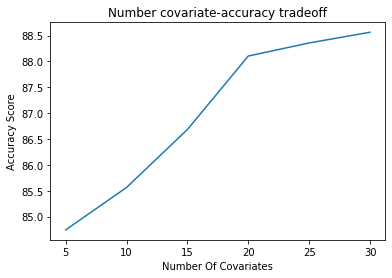

In [24]:
# Putting results in data frame to plot the trade-off.
data = {'Number Of Covariates':  [5, 10, 15, 20, 25, 30],
        'Accuracy Score': [84.741, 85.562, 86.683, 88.104, 88.357,88.564]
        }

trade_off = pd.DataFrame (data, columns = ['Number Of Covariates','Accuracy Score'])

# Plotting data
trade_off_plot = sns.lineplot(data=trade_off, x="Number Of Covariates", y="Accuracy Score")
trade_off_plot.set_title("Number covariate-accuracy tradeoff")
# Saving plot (IF you want to save, uncomment the next two lines.)
# figure_save = trade_off_plot.get_figure()
# figure_save.savefig("trade-off.png")

# Previewing plot
plt.show()

From the above plot, we can conclude that every single covariate has information to offer that allows us to predict with higher accuracy. However the final 10 covariates bring only an extra of 0.4% accuracy. If the following covariates are very expensive to collect:
 
 1. cat14
 2. cat4
 3. cat6
 4. cat9
 5. cat3
 6. cat11
 7. cat17
 8. cat5
 9. cat12
 10. cat13
 
From the result table obtained in [3.4] we see the last 7 important covariates [cat9 - cat13] do not constribute even 1% in our prediction importance. With all these being said, by ommiting these dimensios from the data collection could benefit in the financial cost of the company.
 